## Writeup 

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./output_images/image_with_corners.png "Undistorted"
[image2]: ./output_images/undistorted_chessboard.png
[image3]: ./output_images/undistorted_image.png
[image4]: ./output_images/binary_image.png
[image5]: ./output_images/region_of_interest.png
[image6]: ./output_images/binary_warped.png
[image7]: ./output_images/perspective_transform_points.png
[image8]: ./output_images/lanes_found.png
[image9]: ./output_images/perspective_transform_polyfill.png
[image10]: ./output_images/inverse_perspective_transform_polyfill.png
[image11]: ./output_images/lane_area.png
[video1]: ./project_video_output.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first 3 code cells of the IPython notebook "code.ipynb" .

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objectpoints` and `imagepoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]
![alt text][image2]


### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
![alt text][image3]

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps 
in function `get_binary_imagev3())`.  I tried to seperately detect yellow and white lies.
Even though the HLS S channel is picking up on both, I mainly use it for detecting yellow lines. 

In an earlier version my function was easily confused by shadows, so now I am using the LUV L channel to filter these out.

To detect white lines I am using the R channel from RGB and the V channel from HSV, each with a high treshhold to not pick up anything else. Additionally I implemented Magnitude of the Gradient, Direction of the Gradient and Absolute Sobel fine tuned to find the smaller Spots between the longer white lines.

Here's an example of my output for this step. 

![alt text][image4]

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warp()`. Before using that function the image is cropped
using the `region_of_interest()` function that is similar to the one used in project 1.
 The `warp()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points. 
  I chose the hardcode the source and destination points in the following manner:

```python
src = np.float32([[730, 470],[1080, 720],[200, 720], [560, 470]])
dst = np.float32([[1100,0], [1100,720],[200,720], [200,0]])
```

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto 
a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

Cropping this image with `region_of_interest()` leads to:

![alt text][image5]

Using the `warp()` function for the perspective transform: First step is to identify the destinations points manually.

![alt text][image7]

This is the result:

![alt text][image6]
#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

To find the lane line pixels I used the sliding window search as provided in the lecture. Finding the lane lines is split into 2 seperate parts. First I use the `first_search()` function to initially find lane lines. Once a line is found, the `following_search()` function searches in a margin around previous lines.

Because there are several bad frames in the video, I decided to use a running average to fill the void in the frames where the functions mentioned above have problems detecting a good line. I also use a sanity check to filter bad lines. If the difference in radius between the right and the left line is too big, I also use the previously calculated running average.

![alt text][image8]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Calculation of the radius and center-offset is part of my final pipeline function `pipeline()` at the bottom of the notebook. I used the radius formula shown in the lecture.
To calculate the center-offset I compare the center of both lines to the center of the image.

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step as a part of my final pipeline function `pipeline()`. First I fill an area in the transformed space:

![alt text][image9]

Then I use the inverse transform to get back into normal space:
![alt text][image10]

A weighted image with the original undistored image leads to the final result:

![alt text][image11]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

The video can be found in the "running" branch of the project github repo.


---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

I had quite a lot of problems finding the right tresholds. Especially reliably finding the white lines on the right side without picking up things like shadows or the lighter road. My pipeline is working quite nicely on each test image but still sometimes failing on the video.

The radius calculation leads to unrealistically large values in some frames, so there is still Room for improvement. I tried it, but failed to come up with a better solution because in these frames the lines seem to fit nicely and the radius calculation is derived from the polynomial coefficients.

As a solution I am trying to keep a running averge of the radius and replacing the bad frames with it as I already did with the polynomial coefficients.


In [1]:
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

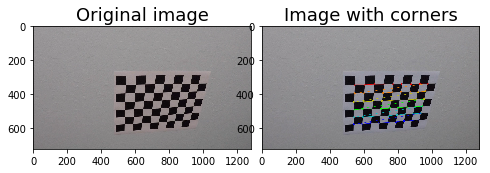

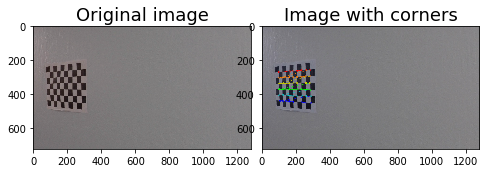

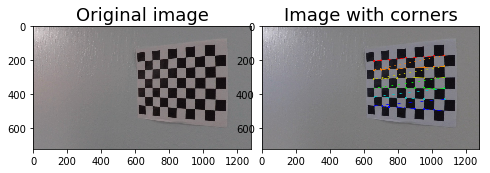

In [2]:
nx = 9
ny = 6
objectpoints = []
imagepoints = []

#Generate object points like (0,0,0), (1,0,0), (2,0,0) ...
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Search for chessboard corners
i = 0
for fname in glob.glob("camera_cal/calibration*.jpg"):
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Convert to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    i = i + 1
    # Draw and display the corners
    if (i < 5):
        if ret is True:
            imagepoints.append(corners)
            objectpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            f.subplots_adjust(hspace = .2, wspace=.05)
            ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
            ax1.set_title('Original image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Image with corners', fontsize=18)
            plt.show()

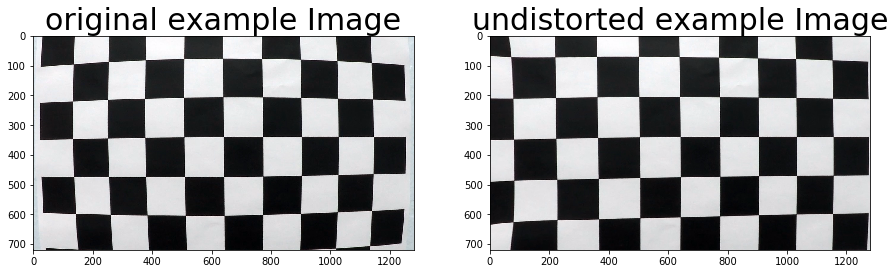

In [3]:
# Undistort plot on an example image
img = cv2.imread(os.path.join('camera_cal', 'calibration1.jpg'))
# Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, gray.shape[::-1], None, None)
# Undistorting
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(img)
ax1.set_title('original example Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('undistorted example Image', fontsize=30)
plt.show()

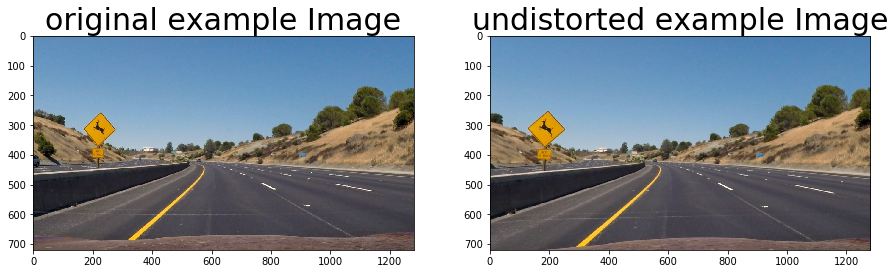

In [4]:
#  An example of a distortion corrected image
image = cv2.imread(os.path.join('test_images', 'test2.jpg'))
imshape = image.shape
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(image)
ax1.set_title('original example Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('undistorted example Image', fontsize=30)
plt.show()

In [5]:
# A function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# A function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(25, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# A function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

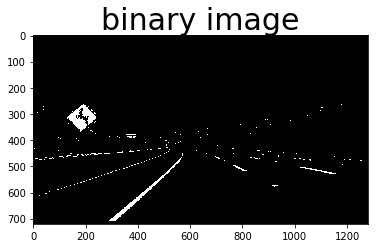

In [6]:
def get_binary_imagev3(img):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    def thresh(img, thresh_min, thresh_max):
        ret = np.zeros_like(img)
        ret[(img >= thresh_min) & (img <= thresh_max)] = 1
        return ret

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = HLS[:,:,0]
    L_HLS = HLS[:,:,1]
    S = HLS[:,:,2]
    
    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L_LUV = LUV[:,:,0]
    U = LUV[:,:,1]
    V = LUV[:,:,2]
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H_HSV = HSV[:,:,0]
    S_HSV = HSV[:,:,1]
    V_HSV = HSV[:,:,2]
    
    t_white_R = thresh(R,220,255)
    t_white_V_HSV = thresh(V_HSV,230,255)
    
    #Use L_LUV channel to filter shadows
    t_yellow_L_LUV = thresh(L_LUV,50,255)
    t_yellow_S = thresh(S,100,255)
    
    gradx = abs_sobel_thresh(gray_img,'x', thresh_min=10, thresh_max=200)
    mag_binary = mag_thresh(gray_img, sobel_kernel=3, mag_thresh=(100, 255))
    dir_binary = dir_threshold(gray_img, sobel_kernel=3, thresh=(np.pi/6, np.pi/2))
    
    # selection for pixels where both the x and y gradients meet the threshold criteria,
    # or the gradient magnitude and direction are both within their threshold values.
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[(gradx == 1) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Detect White lines and yellow Lines seperately
    white = np.zeros((img.shape[0],img.shape[1]))
    yellow = np.zeros((img.shape[0],img.shape[1]))
    combined = np.zeros((img.shape[0],img.shape[1]))
    yellow[(t_yellow_S==1) & (t_yellow_L_LUV==1)] = 1
    white[(t_white_R==1) | (t_white_V_HSV==1) | (combined_grad==1)] = 1
    combined[(white==1)|(yellow==1)] = 1 
    
    return white

combined_binary = get_binary_imagev3(undist)
# Plotting thresholded images
plt.imshow(combined_binary, cmap='gray')
plt.title('binary image', fontsize=30)
plt.show()

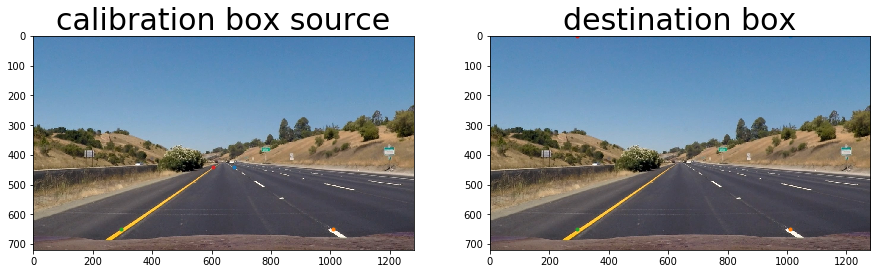

In [7]:
# Code to choose 4 Points in an interative window
import matplotlib.image as mpimage
%matplotlib inline

imagee = mpimage.imread(os.path.join('test_images', 'straight_lines1.jpg'))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(imagee)
ax1.set_title('calibration box source', fontsize=30)
ax1.plot(675, 440, '.') #top right
ax1.plot(1010, 650, '.') #bottom right
ax1.plot(294, 650, '.') #bottom left
ax1.plot(605, 440, '.') #top left

ax2.imshow(imagee)
ax2.set_title('destination box', fontsize=30)
ax2.plot(1010, 0, '.') #top right
ax2.plot(1010, 650, '.') #bottom right
ax2.plot(294, 650, '.') #bottom left
ax2.plot(294, 0, '.') #top left
plt.show()

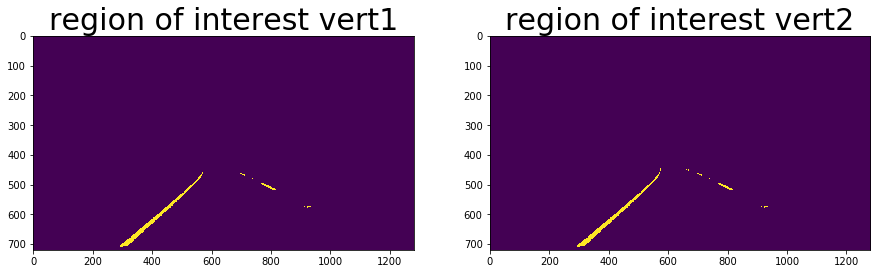

In [8]:
imshape = img.shape
vertices1 = np.array([[(0,imshape[0]),(550, 460), (700, 460), (imshape[1],imshape[0])]], dtype=np.int32)
vertices2 = np.array([[(0,imshape[0]),(585, 440), (690, 440), (imshape[1],imshape[0])]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

masked_image = region_of_interest(combined_binary, vertices1)
masked_image2 = region_of_interest(combined_binary, vertices2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(masked_image)
ax1.set_title('region of interest vert1', fontsize=30)

ax2.imshow(masked_image2)
ax2.set_title('region of interest vert2', fontsize=30)
plt.show()

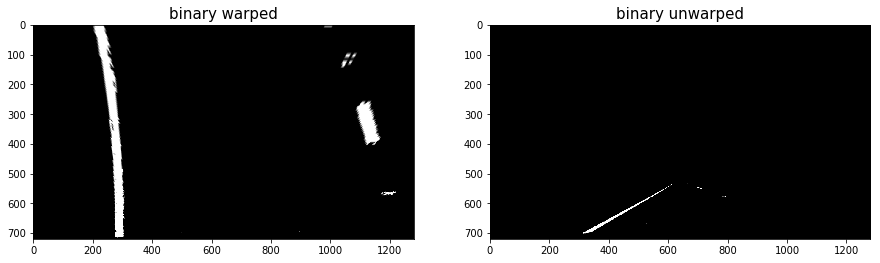

In [9]:

#src = np.float32([[490, 482],[810, 482],[1250, 720], [40, 720]])
#dst = np.float32([[0, 0], [1280, 0],[1250, 720], [40, 720]])

# Define perpective transform function
def warp(img):
    #Define calibration box in source(original) and destination(desired or warped) coordinates
    
#     src = np.float32([[750, 488],[1010, 650],[294, 650], [539, 488]])
#     dst = np.float32([[1010, 488], [1010, 650],[294, 650], [294, 488]])
#     src = np.float32([[675, 440],[1010, 650],[294, 650], [605, 440]])
#     dst = np.float32([[1010, 0], [1010, 650],[294, 650], [294, 0]])
#     src = np.float32([[490, 482],[810, 482],[1250, 720], [40, 720]])
#     dst = np.float32([[0, 0], [1280, 0],[1250, 720], [40, 720]])
    src = np.float32([[730, 470],[1080, 720],[200, 720], [560, 470]])
    dst = np.float32([[1100,0], [1100,720],[200,720], [200,0]])

    # Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M
    binary_warped = cv2.warpPerspective(img, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    binary_unwarped = cv2.warpPerspective(img, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return binary_warped, binary_unwarped, Minv
    
binary_warped, binary_unwarped, Minv = warp(masked_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(binary_warped, cmap="gray")
ax1.set_title('binary warped', fontsize=15)

ax2.imshow(binary_unwarped, cmap="gray")
ax2.set_title('binary unwarped', fontsize=15)
plt.show()



In [10]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

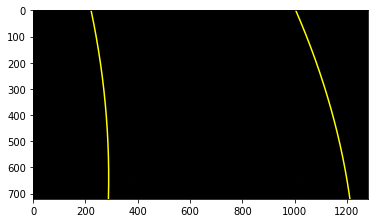

In [11]:
# visualize the result 
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = binary_warped.shape[0]
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Radius: ',left_curverad, 'm', right_curverad, 'm')

# Center offset = Middle of both lines to middle of the picture in m
left_line_bot = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_line_bot = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
mid_bot = (left_line_bot + right_line_bot) / 2
mid_photo = image.shape[1] / 2
off_center = (mid_bot - mid_photo) * xm_per_pix
offset_string = "Center offset: %.2f m" % off_center
print(offset_string)



Radius:  997.14169278 m 802.275237529 m
Center offset: 0.58 m


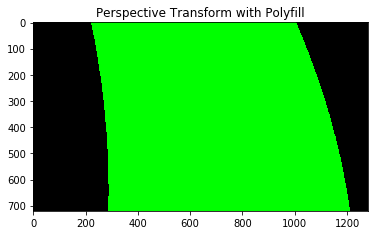

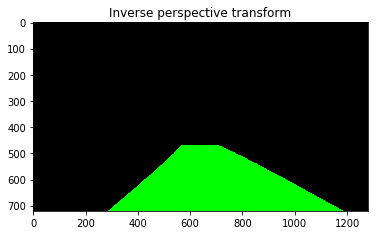

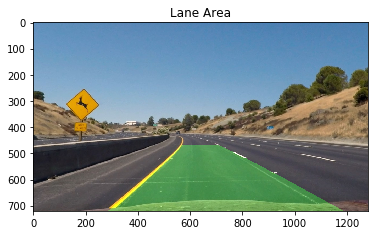

In [13]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8) 
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
plt.imshow(color_warp)
plt.title('Perspective Transform with Polyfill')
plt.show()

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(newwarp)
plt.title('Inverse perspective transform')
plt.show()

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.title('Lane Area')
plt.show()

# Video Pipeline

# Helperfunctions 

In [14]:

imshape = img.shape

def get_binary_imagev2(img, s_thresh=(150, 255), sx_thresh=(40, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def get_binary_image(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def new_search(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, left_fit, right_fit

def followup_search(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, left_fit, right_fit

In [18]:

def pipeline(file):
    # storing the polynomial coefficients of previously found lines
    global prev_leftcoeffs
    global prev_rightcoeffs

    # store average line coordinates from previous n frames
    global moving_rightlines
    global moving_leftlines
    
    global radius
    
    # Clear figure
    plt.clf()
    
    # Undistort, perspective transform, 
    undist = cv2.undistort(file, mtx, dist, None, mtx)
    combined_binary = get_binary_imagev3(undist)
    masked_image = region_of_interest(combined_binary, vertices2)
    binary_warped, binary_unwarped, Minv = warp(masked_image)
    
    # If left lane or right lane are empty, initial new search
    if(prev_leftcoeffs is None) or (prev_rightcoeffs is None):
        ploty, left_fitx, right_fitx, left_fit, right_fit = new_search(binary_warped)
        print('Yep')
    else:
        ploty, left_fitx, right_fitx, left_fit, right_fit = followup_search(binary_warped,
                                                                            prev_leftcoeffs, prev_rightcoeffs)
#         ploty, left_fitx, right_fitx, left_fit, right_fit = new_search(binary_warped)
    
    ## Keep a moving average of last n frames
    n = 12
    length_rightlines = len(moving_rightlines)
    if(length_rightlines < n):
        moving_rightlines.append(right_fit)
        length_rightlines = len(moving_rightlines)
        movingaverage_right = [sum(col)/length_rightlines for col in zip(*moving_rightlines)]
    else:
        moving_rightlines.pop(0)
        moving_rightlines.append(right_fit)
        movingaverage_right = [sum(col)/n for col in zip(*moving_rightlines)]
    
    length_leftlines = len(moving_leftlines)
    if(length_leftlines < n):
        moving_leftlines.append(left_fit)
        length_leftlines = len(moving_rightlines)
        movingaverage_left = [sum(col)/length_leftlines for col in zip(*moving_leftlines)]
    else:
        moving_leftlines.pop(0)
        moving_leftlines.append(left_fit)
        movingaverage_left = [sum(col)/n for col in zip(*moving_leftlines)]
        
    ## Sanity Check -  if the difference in radius is too big use the moving average
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = binary_warped.shape[0]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Check if left and right curve radius fit together
    if(abs(left_curverad/right_curverad) < 0.5) or (abs(left_curverad/right_curverad) > 2):
        #If they don't fit, try a new search
        ploty, left_fitx, right_fitx, left_fit, right_fit = new_search(binary_warped)
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = binary_warped.shape[0]
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # If they still don't fit, use the moving average
        if(abs(left_curverad/right_curverad) < 0.5) or (abs(left_curverad/right_curverad) > 2):
            left_fit = movingaverage_left
            right_fit = movingaverage_right
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    average_curverad = (left_curverad + right_curverad)/2
    
    # Use a running average of the radius to filter failure in some frames
    if average_curverad > 2000:
        length_radius = len(radius)
        if(length_radius < 10):
            radius.append(average_curverad)
            length_radius = len(radius)
            movingaverage_radius = sum(radius)/length_radius
        else:
            radius.pop(0)
            radius.append(average_curverad)
            movingaverage_radius = sum(radius)/10
        curvature_string = "Radius: %.2f m" % movingaverage_radius
    else:
        curvature_string = "Radius: %.2f m" % average_curverad
        
    # Center offset = Middle of both lines to middle of the picture in m
    left_line_bot = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_line_bot = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    mid_bot = (left_line_bot + right_line_bot) / 2
    mid_photo = image.shape[1] / 2
    off_center = (mid_bot - mid_photo) * xm_per_pix
    offset_string = ("Center offset: %.2f m" % off_center)
    
    ## Plot results 
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8) 
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.putText(result,curvature_string, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result,offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    prev_leftcoeffs = left_fit
    prev_rightcoeffs = right_fit
    return result

## Pipleline Test on single image

In [ ]:
# prev_leftcoeffs = None
# prev_rightcoeffs = None
# moving_rightlines = []
# moving_leftlines = []

# image = cv2.imread(os.path.join('test_images', 'test2.jpg'))
# result = pipeline(image)
# plt.imshow(result)
# plt.show()



In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

prev_leftcoeffs = None
prev_rightcoeffs = None
radius = []
moving_rightlines = []
moving_leftlines = []

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

Yep
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 13%|█▎        | 161/1261 [00:57<06:58,  2.63it/s]


 25%|██▌       | 321/1261 [01:56<05:20,  2.93it/s]


 38%|███▊      | 481/1261 [03:05<06:18,  2.06it/s]


 51%|█████     | 641/1261 [04:20<03:59,  2.59it/s]


 64%|██████▎   | 801/1261 [05:36<04:03,  1.89it/s]


 76%|███████▌  | 961/1261 [07:10<02:37,  1.90it/s]


 89%|████████▊ | 1119/1261 [08:24<01:02,  2.29it/s]


 97%|█████████▋| 1224/1261 [09:18<00:17,  2.12it/s]